# Community detection using Spectral Clustering

Given graph $G$ with $n$ nodes, find non-overlapping node "communities": $k$ groups of nodes that are densely intra connected and have low number of inter connections.

- Compute square diagonal matrix of node degrees $D$. 
    $$D_{ii} = \sum_i A_{ij}, D_{ij} = 0, i \neq j$$
- Construct graph Laplacian 
    $$L_{unnormed} = D - A$$
Find $0 = \lambda_0 \leq \lambda_1 \leq \lambda_2 \leq \ldots \leq \lambda_m$ smallest eigenvalues of $L$ and construct matrix $X$ by stacking $m$ corresponding eigenvectors ($v_1, \ldots v_m$) as columns of $X$. Matrix $X$ has size $n \times m$, its rows are "spectral representaion" of graph nodes.
   
- Run k-means algorithm on matrix X and assign nodes with labels obtained by k-means.

---

Use 3 versions of a Laplacian:

- Unnormalized Laplacian: $L = D - A$
- Symmetric normalization: $L_{sym} = I - D^{-\frac{1}{2}} \cdot A \cdot D^{-\frac{1}{2}}$
- Random Walk normalization: $L_{rw} = I - D^{-1} \cdot A$
    
Sources:
1. Andrew Ng paper on spectral clustering https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf
2. Tutorial on spectral clustering with multiple theoretical views on the problem https://arxiv.org/abs/0711.0189
3. Amazing explanation from James R. Lee https://www.youtube.com/watch?v=8XJes6XFjxM

In [1]:
# this is used for 2 dimensional visualization 
# https://github.com/stat-ml/ncvis-examples/tree/master/utils

import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

from scipy.interpolate import interp1d
def scatter_classes(xs, y, ax, show_labels=True, silhouette_coefficient=False, **kwargs):
    if silhouette_coefficient:
        from sklearn.metrics import silhouette_samples
        scores = silhouette_samples(xs, y)
        labels = np.unique(y)
        n_labels = labels.shape[0]
        macro_scores = np.empty(n_labels)
        for i in range(n_labels):
            macro_scores[i] = np.mean(scores[y == labels[i]])
        score = np.mean(macro_scores)
        std_score = np.std(macro_scores)

        props = dict(boxstyle='round', facecolor='grey', alpha=0.1, linewidth=0)
        info = 'Silhouette Coefficient = {:.3f}±{:.3f}'
    
    # Interpolating the discrete colormap
    n = 12
    ps = np.linspace(0, 1, n)
    cs = plt.cm.Set3(ps)
    f = interp1d(ps, cs.T)
    nclasses = len(np.unique(y))
    custom_cycler = cycler(color=f(np.linspace(0, 1, nclasses)).T)
    ax.set_prop_cycle(custom_cycler)
    n_dims = xs.shape[-1]
    for k in np.unique(y):
        npoints = np.count_nonzero(y==k)
        x1 = x2 = None

        class_mask = (y==k)
        if n_dims == 2:
            x1 = xs[class_mask, 0]
            x2 = xs[class_mask, 1]
        elif n_dims == 1:
            x1 = xs[class_mask, 0]
            x2 = np.random.uniform(0, 1, npoints)
        
        ax.scatter(x1, x2, label="{}".format(k) if show_labels else None, **kwargs)
        
    if show_labels:
        ax.legend(loc='upper right')
    if silhouette_coefficient:
        ax.text(0.01, 0.01, info.format(score, std_score), fontsize=14, bbox=props, transform=ax.transAxes)

In [2]:
import numpy as np
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics.cluster import adjusted_rand_score
import community

from scipy.linalg import sqrtm
from sknetwork.clustering import modularity

import ncvis
from umap import UMAP
from sklearn.manifold import TSNE

## 1. Compare 3 versions of Spectral clustering on `Karate Club dataset`
    
Implement 3 algorithms described in https://arxiv.org/abs/0711.0189 :
1. Unnormalized spectral clustering 
2. Normalized spectral clustering according to Shi and Malik (2000)
3. Normalized spectral clustering according to Ng, Jordan, and Weiss (2002)

using `Adjusted Rand Index` (3 pairwise comparisons), `Modularity` (3 numbers) and visually, plotting points in a corresponding 2 dimensional spaces (spanned by eigenvectors).

Theoretical questions:
4. Why does the smallest eigenvalue of unnormalized Laplacian is always equal to 0? 
5. From network point of view, what does Symmetric normalization do? 
6. Under what conditions Symmetric and Random walk normalizations yield the same result? 
  

In [3]:
karate = nx.karate_club_graph()

In [4]:
y_true = [karate._node[i]['club'] == 'Mr. Hi' for i in karate.nodes]

### Unnormalized spectral clustering

In [5]:
from sklearn.preprocessing import normalize

In [6]:
#Build adj_matrix
A = np.array(nx.adj_matrix(karate).todense())
D = np.diag(A.sum(axis=1))

# Construct unnormalized Laplacian
L = D - A

# Compute eigenvectors
_, vectors = np.linalg.eigh(L)
spectral_embedding_unnormalized = vectors

#K-means
node_colors_unnormalized = KMeans(2).fit_predict(spectral_embedding_unnormalized[:, :2])

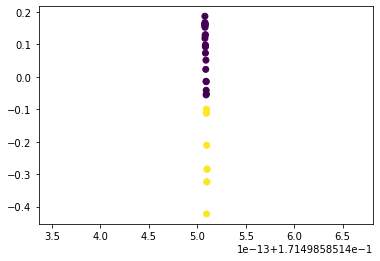

In [7]:
plt.scatter(spectral_embedding_unnormalized[:, 0].T, spectral_embedding_unnormalized[:, 1].T, c=node_colors_unnormalized)
plt.show()

### Normalized spectral clustering according to Shi and Malik (Random Walk)

In [8]:
#Build adj_matrix
A = np.array(nx.adj_matrix(karate).todense())
D = np.diag(A.sum(axis=1))

# Construct normalized Laplacian
L = D - A
L_rw = np.linalg.inv(D) @ L

# Compute eigenvectors
_, vectors = np.linalg.eigh(L_rw)
spectral_embedding_rw = vectors

#K-means
node_colors_spectral_rw = KMeans(2).fit_predict(spectral_embedding_rw[:, :2])

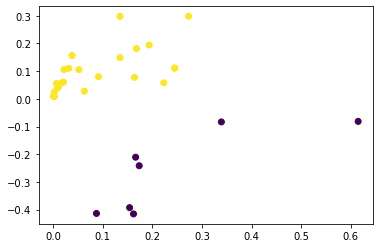

In [9]:
plt.scatter(spectral_embedding_rw[:, 0].T, spectral_embedding_rw[:, 1].T, c=node_colors_spectral_rw)
plt.show()

### Normalized spectral clustering according to Ng, Jordan, and Weiss (Symmetric)

In [10]:
# Construct normalized Laplacian
L_sym = sqrtm(np.linalg.inv(D)) @ L @ sqrtm(np.linalg.inv(D))

# Compute eigenvectors
_, vectors = np.linalg.eigh(L_sym)
spectral_embedding_sym = vectors

#Normalize matrix
spectral_embedding_sym = Normalizer().transform(spectral_embedding_sym[:, :2])

#K-means
node_colors_spectral_sym = KMeans(2).fit_predict(spectral_embedding_sym)

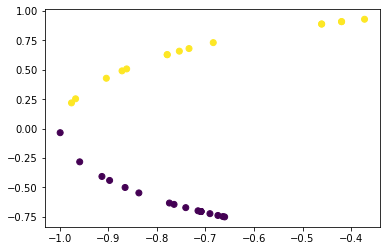

In [11]:
plt.scatter(spectral_embedding_sym[:, 0].T, spectral_embedding_sym[:, 1].T, c=node_colors_spectral_sym)
plt.show()

### Adjusted Rand Index (pairwise comparisons)

In [12]:
#between unnormalized and normalized according to Shi and Malik (Random Walk)
round(adjusted_rand_score(node_colors_unnormalized, node_colors_spectral_rw),3)

0.652

In [13]:
#between unnormalized and normalized according to Ng, Jordan, and Weiss (Symmetric)
round(adjusted_rand_score(node_colors_unnormalized, node_colors_spectral_sym),3)

0.484

In [14]:
#between Symmetric and Random Walk
round(adjusted_rand_score(node_colors_spectral_sym, node_colors_spectral_rw),3)

0.262

__Conclusion:__ According to the Rand Index clusterings that were buld by unnormalized and normalized with Random Walk are the most similar to each other. (The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.)

### Adjusted Rand Index (comparisons with true labels)

In [15]:
#for unnormalized
round(adjusted_rand_score(node_colors_unnormalized, y_true),3)

0.329

In [16]:
#for normalized (Random Walk)
round(adjusted_rand_score(node_colors_spectral_rw, y_true),3)

0.153

In [17]:
#for normalized (Symmetric)
round(adjusted_rand_score(node_colors_spectral_sym, y_true),3)

0.772

__Conclusion:__ Symmetric normalization shows the best results according to the adjusted_rand_score.

### Modularity

In [18]:
#unnormalized
round(modularity(A,node_colors_unnormalized),3)

0.234

In [19]:
# random walk normalizaion
round(modularity(A,node_colors_spectral_rw),3)

0.193

In [20]:
#symmetric normalization
round(modularity(A,node_colors_spectral_sym),3)

0.36

__Conclusion:__ Modularity is one measure of the structure of graphs. As it can be seen Symmetric normalization gives the best modularity score. High modularity means that graph is structural, in other words there is dense connections between the nodes within modules and sparse connections between nodes in different modules. 

### Theoretical questions

__1__
- Matrices $D$ and $A$ are symmetric ($D$ is diagonal and $A$ is adjacency).

- We can prove that matrix $L = D-A$ is positive semi-definite:
$$
x^{T} L x =x^{T} D x-x^{T} A x=\sum_{i=1}^{n} d_{i} x_{i}^{2}-\sum_{i, j=1}^{n} x_{i} x_{j} a_{i j} \\
=\frac{1}{2}\left(\sum_{i=1}^{n} d_{i} x_{i}^{2}-2 \sum_{i, j=1}^{n} x_{i} x_{j} a_{i j}+\sum_{j=1}^{n} d_{j} x_{j}^{2}\right)=\frac{1}{2} \sum_{i, j=1}^{n} a_{i j}\left(x_{i}-x_{j}\right)^{2}
$$
Due to that fact the eigenvalues of $L$ are always non-negative.

- If we take constant vector $x = (1,...,1)^T$ as an eigenvector then the corresponding eigenvalue is equal to zero.

Hence, the smallest eigenvalue of $L$ is equal to zero.

__2__ 

Symmetric normalization: $$L_{sym} = I - D^{-\frac{1}{2}} \cdot A \cdot D^{-\frac{1}{2}} = \left(\begin{array}{cccc}
\frac{\sum_{j \neq 1} a_{1, j}}{\sqrt{d_{1} d_{1}}} & -\frac{a_{1,2}}{\sqrt{d_{1} d_{2}}} & \cdots & -\frac{a_{1, n}}{\sqrt{d_{1} d_{n}}} \\
-\frac{a_{2,1}}{\sqrt{d_{2} d_{1}}} & \frac{\sum_{j \neq 2} a_{2, j}}{\sqrt{d_{2} d_{2}}} & \cdots & -\frac{a_{2, n}}{\sqrt{d_{2} d_{n}}} \\
\vdots & \vdots & \ddots & \vdots \\
-\frac{a_{n, 1}}{\sqrt{d_{n} d_{1}}} & -\frac{a_{n, 2}}{\sqrt{d_{n} d_{2}}} & \cdots & \frac{\sum_{j \neq n} a_{n, j}}{\sqrt{d_{n} d_{n}}}
\end{array}\right)$$

$d_i$ - degree of vertex i 

Therefore, symmetric normalization normalizes the adjacency matrix so that the element $a_{ij}$ is divided by the root of the product of the degree of the vertex $i$ and $j$.

__3__ 


First explanation:

$L_{sym} = L_{rw}$ 

$I - D^{-\frac{1}{2}} \cdot A \cdot D^{-\frac{1}{2}} = I - D^{-1} \cdot A$

$D^{-\frac{1}{2}} \cdot A \cdot D^{-\frac{1}{2}} =D^{-1} \cdot A$

$A \cdot D^{-\frac{1}{2}} = D^{-\frac{1}{2}} \cdot A$

Therefore, $L_{sym} = L_{rw}$  if $A \cdot D^{-\frac{1}{2}}$ satisfy the commutativity property.

Second explanation:

- Symmetric normalization normalizes the adjacency matrix so that the element $a_{ij}$ is divided by the root of the product of the degree of the vertex $i$ and $j$.
- Random walk normalization normalizes the matrix by dividing it by the vertex degree of only one vertex.

These normalizations are equal if any two connected vertices have the same degrees.

# Unsupervised node prediction

## 2. Random Walk based embeddings

Use data from https://github.com/shchur/gnn-benchmark/tree/master/data/npz , particulary use Amazon Computers dataset, see description in a corresponding paper https://arxiv.org/pdf/1811.05868.pdf. 
> Recall that this network has small amount of isolated nodes.

1. Run `DeepWalk` to get embeddings of size 32.
2. Using `kmeans` with appropriate number of clusters (somewhere between 6 and 12) compute node labels. Compare the result with ground truth communities using `adjusted_rand_index`. Compute corresponding `Modularities`.
3. Run your favourite dimensionality reduction algorithm to get a 2 dimensional embedding.
4. Compare results (repeate 1-3) with embeddings of size 64 and 128.
5. Compare results with supervised Logistic Regression on data feature matrix (without using network data).


Recommended for visualization:

- Dmitry Ulyanov has nice multicore tsne implementation https://github.com/DmitryUlyanov/Multicore-TSNE
- Recent paper from Aleksandr Artemenkov and Maxim Panov https://arxiv.org/pdf/2001.11411.pdf with implementation https://github.com/alartum/ncvis . Reported to be superior to TSNE for the purpose of 2 dimensional visualization.

### 1. DeepWalk to get embeddings of size 32, 64 and 128

In [21]:
def load_npz_to_sparse_graph(file_name):
    """Load a SparseGraph from a Numpy binary file.
    from https://github.com/shchur/gnn-benchmark/blob/master/gnnbench/data/io.py
    """
    from scipy.sparse import csr_matrix
    with np.load(file_name) as loader:
        loader = dict(loader)
        adj_matrix = csr_matrix((loader['adj_data'], loader['adj_indices'], loader['adj_indptr']),
                                   shape=loader['adj_shape'])
        attr_matrix = csr_matrix((loader['attr_data'], loader['attr_indices'], loader['attr_indptr']),
                                        shape=loader['attr_shape'])
        labels = loader['labels']
        class_names = loader.get('class_names')

    return adj_matrix, attr_matrix, labels, class_names

In [22]:
adj, X, y, class_names = load_npz_to_sparse_graph('amazon_electronics_computers.npz')

In [23]:
X = pd.DataFrame.sparse.from_spmatrix(X)

In [24]:
G = nx.from_scipy_sparse_matrix(adj)

with open('amazon.edgelist', 'w') as f:
    for edge in G.edges:
        f.write(f'{edge[0]} {edge[1]}\n')

In [25]:
#Run DeepWalk to get embeddings of size 32
#!deepwalk --representation-size 32 --format edgelist --input amazon.edgelist --output amazon.embeddings32 --workers 4

In [26]:
#Run DeepWalk to get embeddings of size 64
#!deepwalk --representation-size 64 --format edgelist --input amazon.edgelist --output amazon.embeddings64 --workers 4

In [27]:
#Run DeepWalk to get embeddings of size 128
#!deepwalk --representation-size 128 --format edgelist --input amazon.edgelist --output amazon.embeddings128 --workers 4

In [28]:
with open('amazon.embeddings32', 'r') as f:
    # first line is a header containing `number of nodes` and `embeddings size`
    n, m = map(int, f.readline().split())
    node_embeddings32 = np.zeros((13752, m))
    # remaining lines are node_id and embedding vector components
    for line in f.readlines():
        node_id, *emb = line.split(' ')
        node_embeddings32[int(node_id)] = list(map(float, emb))

In [29]:
with open('amazon.embeddings64', 'r') as f:
    # first line is a header containing `number of nodes` and `embeddings size`
    n, m = map(int, f.readline().split())
    node_embeddings64 = np.zeros((13752, m))
    # remaining lines are node_id and embedding vector components
    for line in f.readlines():
        node_id, *emb = line.split(' ')
        node_embeddings64[int(node_id)] = list(map(float, emb))

In [30]:
with open('amazon.embeddings128', 'r') as f:
    # first line is a header containing `number of nodes` and `embeddings size`
    n, m = map(int, f.readline().split())
    node_embeddings128 = np.zeros((13752, m))
    # remaining lines are node_id and embedding vector components
    for line in f.readlines():
        node_id, *emb = line.split(' ')
        node_embeddings128[int(node_id)] = list(map(float, emb))

After building node embeddings we have to remove from our data nodes that have no edges (isolated nodes):

In [31]:
find_zero = np.array([len(G[i]) for i in range(len(G))])
find_zero = np.where(find_zero == 0)[0]

X = X.drop(find_zero,axis=0)
y_m = y
y = np.delete(y, find_zero, axis=0)
node_embeddings32 = np.delete(node_embeddings32, find_zero, axis=0)
node_embeddings64 = np.delete(node_embeddings64, find_zero, axis=0)
node_embeddings128 = np.delete(node_embeddings128, find_zero, axis=0)

adj = np.array(adj.todense())
adj = np.delete(adj, find_zero, axis=0)
adj = np.delete(adj, find_zero, axis=1)

### 2. Kmeans using embeddings of size 32

In [32]:
score=[]
node_colors=[]
for k in range(6, 13):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(node_embeddings32)
    node_colors_kmeans = kmeans.predict(node_embeddings32)
    node_colors.append(node_colors_kmeans)
    score.append(adjusted_rand_score(y,node_colors_kmeans))

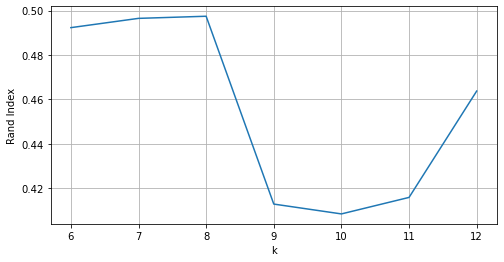

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(range(6, 13), score)
plt.xlabel('k')
plt.ylabel('Rand Index')
plt.grid(True)
plt.show()

As it can be seen, the best number of clusters according to K-means is equal to 8 (the true number of clusters is equal to 10).

In [34]:
score_32 = score[np.argmax(score)]
print(round(score_32,3))

0.497


In [35]:
modularity_64 = modularity(adj,node_colors[np.argmax(score)])
print(round(modularity_64,3))

0.532


#### Visualization and 2 dimensional embeddings

In [36]:
Ys = {}

vis = ncvis.NCVis()
Ys['vis'] = vis.fit_transform(node_embeddings32)

umap = UMAP()
Ys['umap'] = umap.fit_transform(node_embeddings32)

tsne = TSNE()
Ys['tsne'] = tsne.fit_transform(node_embeddings32)

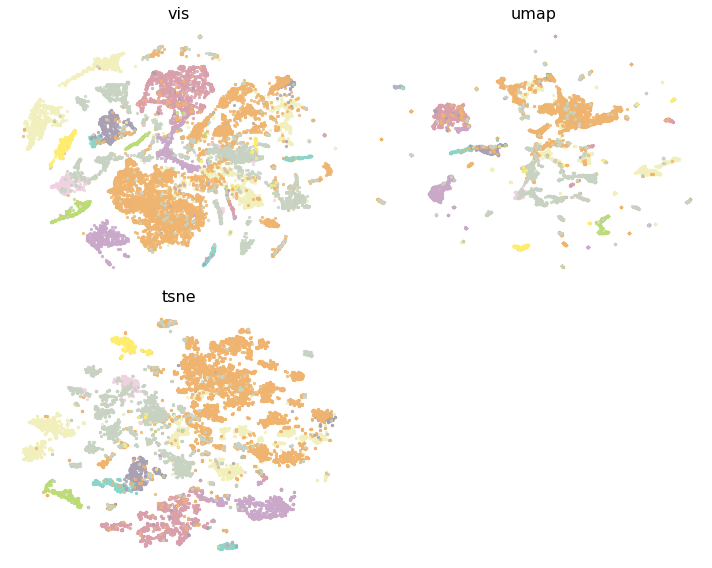

In [37]:
n_cols = 2
n_imgs = len(Ys.items())
n_rows = (n_imgs+n_cols-1)//n_cols 

fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 8))
ax = ax.ravel()

for k, (name, Y) in enumerate(Ys.items()):
    ax[k].set_title(name, fontsize=16)
    ax[k].set_axis_off()
    scatter_classes(Y, y, ax[k], marker='.', s=20, alpha=0.8,
                          show_labels=False)
while k < n_imgs:
    k += 1
    ax[k].set_axis_off()
    
plt.tight_layout()
plt.show()

### 3. Kmeans using embeddings of size 64

In [38]:
score=[]
node_colors=[]
for k in range(6, 13):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(node_embeddings64)
    node_colors_kmeans = kmeans.predict(node_embeddings64)
    node_colors.append(node_colors_kmeans)
    score.append(adjusted_rand_score(y,node_colors_kmeans))

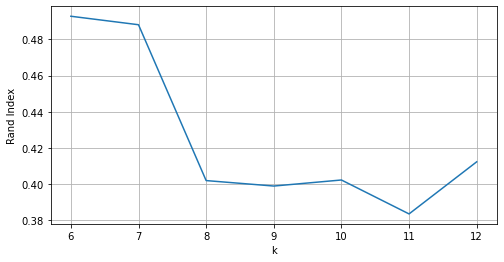

In [39]:
plt.figure(figsize=(8, 4))
plt.plot(range(6, 13), score)
plt.xlabel('k')
plt.ylabel('Rand Index')
plt.grid(True)
plt.show()

In the case of embeddings of size 64, the most appropriate number of clusters is equal to 6. 

In [40]:
score_64 = score[np.argmax(score)]
print(round(score_64,3))

0.493


In [41]:
modularity_64 = modularity(adj,node_colors[np.argmax(score)])
print(round(modularity_64,3))

0.527


#### Visualization and 2 dimensional embedding

In [42]:
Ys = {}

vis = ncvis.NCVis()
Ys['vis'] = vis.fit_transform(node_embeddings64)

umap = UMAP()
Ys['umap'] = umap.fit_transform(node_embeddings64)

tsne = TSNE()
Ys['tsne'] = tsne.fit_transform(node_embeddings64)

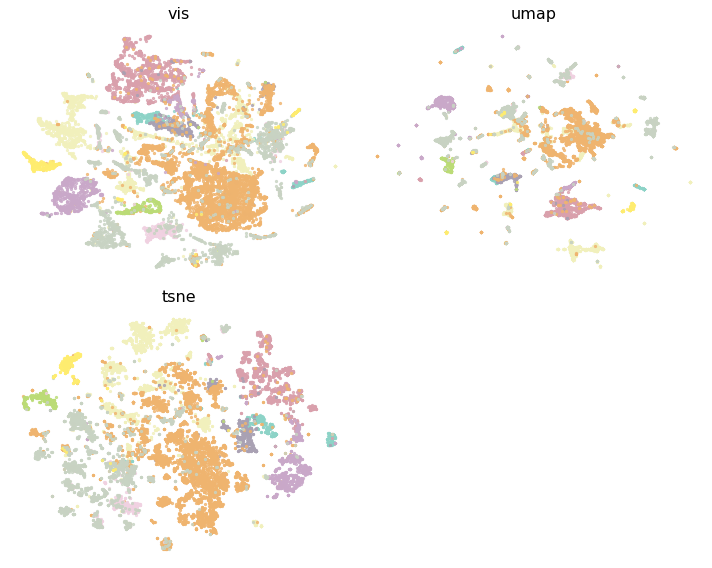

In [43]:
n_cols = 2
n_imgs = len(Ys.items())
n_rows = (n_imgs+n_cols-1)//n_cols 

fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 8))
ax = ax.ravel()

for k, (name, Y) in enumerate(Ys.items()):
    ax[k].set_title(name, fontsize=16)
    ax[k].set_axis_off()
    scatter_classes(Y, y, ax[k], marker='.', s=20, alpha=0.8,
                          show_labels=False)
while k < n_imgs:
    k += 1
    ax[k].set_axis_off()
    
plt.tight_layout()
plt.show()

### 4. Kmeans using embeddings of size 128

In [44]:
score=[]
node_colors=[]
for k in range(6, 13):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(node_embeddings128)
    node_colors_kmeans = kmeans.predict(node_embeddings128)
    node_colors.append(node_colors_kmeans)
    score.append(adjusted_rand_score(y,node_colors_kmeans))

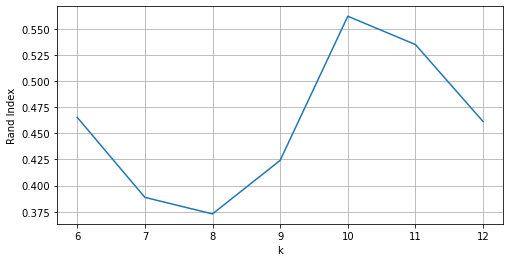

In [45]:
plt.figure(figsize=(8, 4))
plt.plot(range(6, 13), score)
plt.xlabel('k')
plt.ylabel('Rand Index')
plt.grid(True)
plt.show()

Finally, when we use embeddings of size 128 we get the number of clusters equal to 10. And it is equal to the true number of clusters!

In [46]:
score_128 = score[np.argmax(score)]
print(round(score_128,3))

0.562


In [47]:
modularity_128 = modularity(adj,node_colors[np.argmax(score)])
print(round(modularity_128,3))

0.559


#### Visualization and 2 dimensional embedding

In [48]:
Ys = {}

vis = ncvis.NCVis()
Ys['vis'] = vis.fit_transform(node_embeddings128)

umap = UMAP()
Ys['umap'] = umap.fit_transform(node_embeddings128)

tsne = TSNE()
Ys['tsne'] = tsne.fit_transform(node_embeddings128)

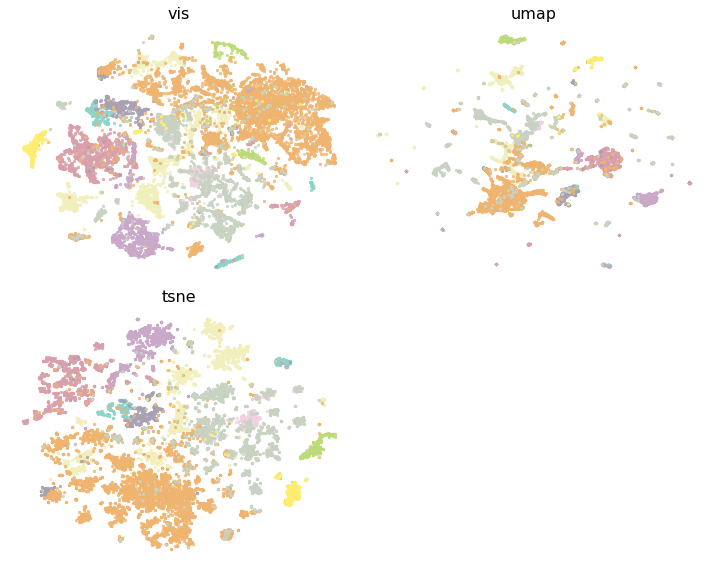

In [49]:
n_cols = 2
n_imgs = len(Ys.items())
n_rows = (n_imgs+n_cols-1)//n_cols 

fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 8))
ax = ax.ravel()

for k, (name, Y) in enumerate(Ys.items()):
    ax[k].set_title(name, fontsize=16)
    ax[k].set_axis_off()
    scatter_classes(Y, y, ax[k], marker='.', s=20, alpha=0.8,
                          show_labels=False)
while k < n_imgs:
    k += 1
    ax[k].set_axis_off()
    
plt.tight_layout()
plt.show()

### 3. Logistic Regression

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
clf = LogisticRegression(random_state=0, max_iter = 1000).fit(X_train, y_train)

In [52]:
y_pred = clf.predict(X_test)

In [53]:
score_lr = adjusted_rand_score(y_test, y_pred)
print(round(score_lr,3))

0.645


__Conclusion:__ Predictions by Logisic Regression has the largest adjusted_rand_score. The second place takes K-means build on embeddings of size 128 (and also this algorithm predicted the correct number of clusters equal to 10).

The largest modularity is achieved by K-means build on embeddings of size 128.

According to the visualizations we can observe 10 more or less distinguishable clusters. 

# 3. Отправка решения.


1. Прогоните свой jupyter notebook: **Kernel** $\rightarrow$ **Restart & Run all**, нотбук **должен** запускаться линейно! Если вы считали эмбединги прямо в нотбуке, можете закоментить соответствующие ячейки. Во втором домашнем задании я **буду** снижать оценку если вы не сделали Restart & Run All.
2. Назовите нотбук `Имя_Фамилия_HA2_networks_2020`, например `Anvar_Kurmukov_HA2_networks_2020`
4. Сохраните нотбук в формате `ipython`.
5. Отправьте файл с нотбуком на почту kurmukovai@gmail.com с темой письма `Имя_Фамилия_HA2_networks_2020`.

---

## Комментарии к решению и выставлению оценки.
Ваш файл с решением должно быть **комфортно читать**:
- **комментируйте** происходящее, лучше всего для этого подходит markdown cells, но можно и в комментариях в ячейках с кодом. Под комментируйте имеется ввиду написание выводов на естественном языке доступном проверяющему (русский или английский). Например, вы нарисовали двумерное вложение и на картинке ничего не понятно, все смешано, это нормально (хотя во втором пункте можно получить более менее неплохое вложение), так и напишите "Не получилось построить...".
- не нужно оставлять все отладочные ячейки нотбука, сохраните свою работу отдельно, а в файле которые отправляете в качестве решения оставьте только нужное.
- **округляйте** значения характеристик точности и модулярности до нескольких значащих цифр (столько сколько целесообразно в каждом отдельном случае), но не более 6.